In [1]:
# All imports
from Imports import *
from Helper import *
from Preprocessing import *

In [2]:
# Load dataset and device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
VALID_FILE = '../Data/2025-Quantum-Tornado-validation_data-160-examples.xlsx'

# Load training data
df_train = pd.read_excel(TRAIN_FILE)
# Load test data
df_test = pd.read_excel(TEST_FILE)
# Load validation data
df_valid = pd.read_excel(VALIDATION_FILE)

if False:
    # Quantum augmented datasets using random shadows
    EXTRA_TRAIN = "../Data/32_featuresXY_train_full_ent.csv"
    EXTRA_TEST  = "../Data/32_featuresXY_test_fullent.csv"
    EXTRA_VALID = "../Data/32_featuresXY_valid_fullent.csv"
    
    # Extra features
    extra_train_df = pd.read_csv(EXTRA_TRAIN)
    extra_test_df = pd.read_csv(EXTRA_TEST)
    extra_valid_df = pd.read_csv(EXTRA_VALID)
    
    # Drop first column by index
    extra_train_df = extra_train_df.drop(extra_train_df.columns[0], axis=1)
    extra_test_df = extra_test_df.drop(extra_test_df.columns[0], axis=1)
    extra_valid_df = extra_valid_df.drop(extra_valid_df.columns[0], axis=1)
    
    # Concatenate extra features (axis=1 for columns)
    df_train = pd.concat([df_train, extra_train_df], axis=1)
    df_test  = pd.concat([df_test, extra_test_df], axis=1)
    df_valid  = pd.concat([df_valid, extra_valid_df], axis=1)
    
for i, row in df_train.head(3).iterrows():
    print(row.tolist())

print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

cuda
<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


(256,)
tensor([[ 0.0133, -0.0256, -0.0111,  ...,  0.0438,  0.0053,  0.0451],
        [ 0.0035, -0.0186,  0.0082,  ..., -0.0869,  0.0034, -0.0962],
        [ 0.0061,  0.0581,  0.0019,  ..., -0.0510, -0.0048, -0.0317],
        ...,
        [-0.0003, -0.0669, -0.0046,  ...,  0.0028,  0.0052,  0.0209],
        [ 0.0044, -0.0581,  0.0032,  ..., -0.1117,  0.0024, -0.1110],
        [-0.0087,  0.0071,  0.0063,  ..., -0.0769,  0.0028, -0.0645]],
       device='cuda:0', dtype=torch.float64)


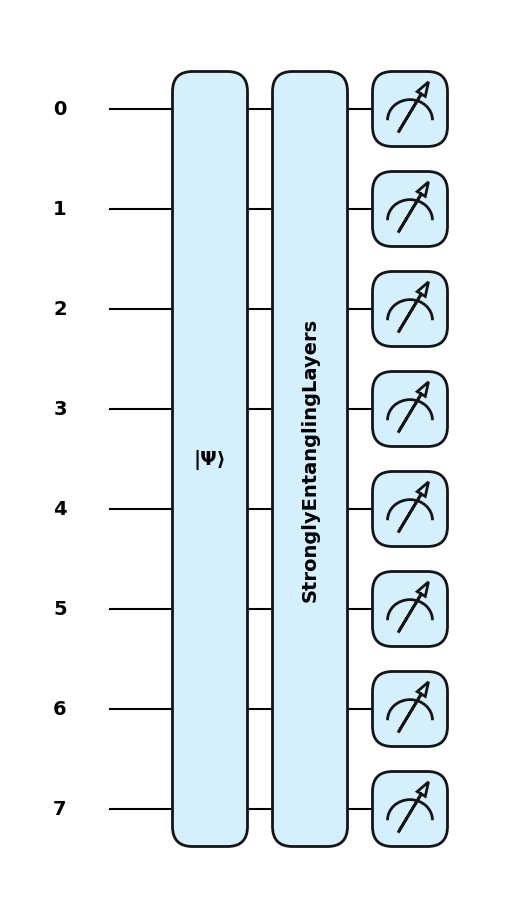

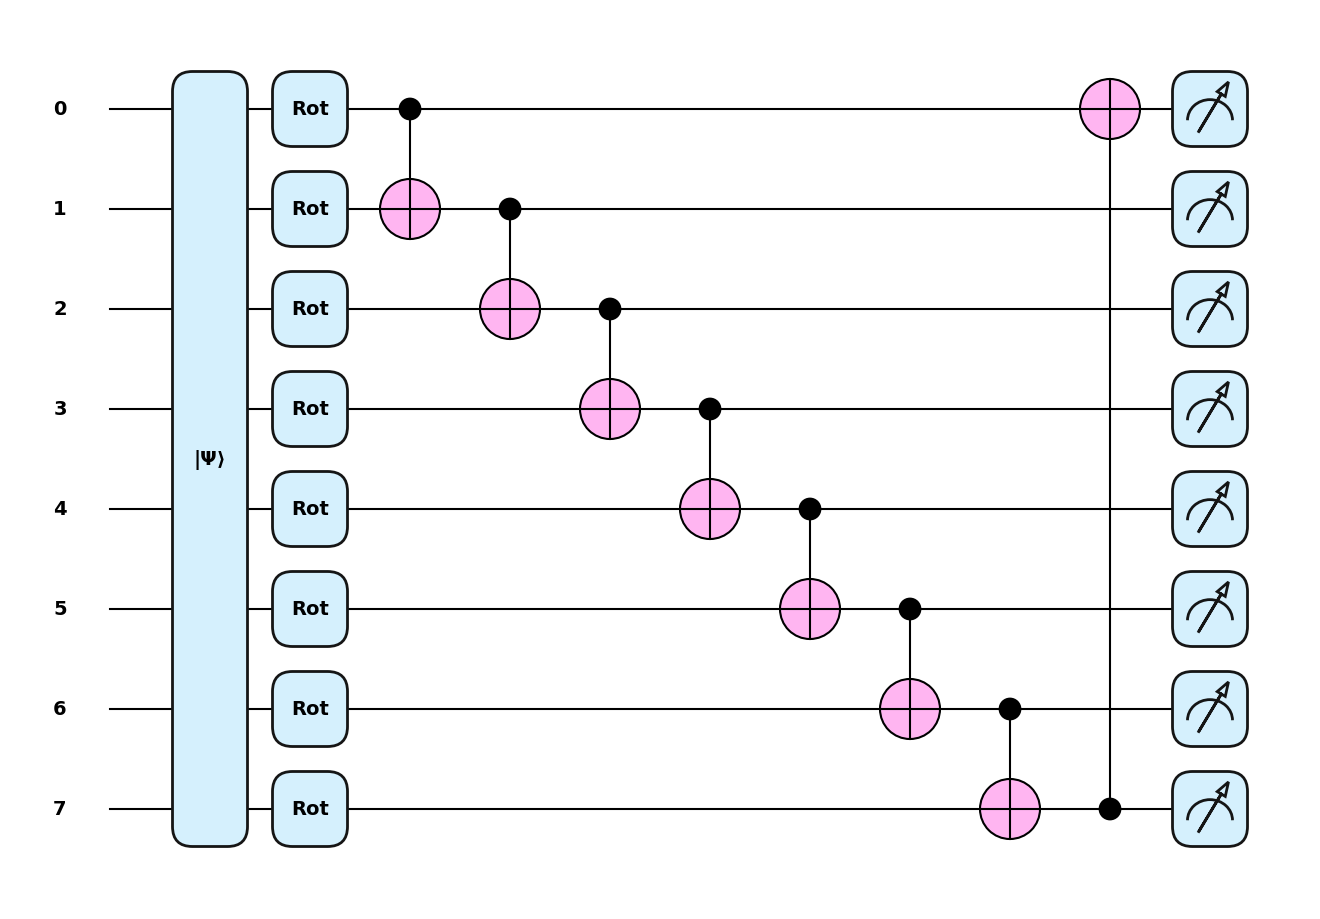

In [3]:
# Quantum circuit and helper functions
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 8, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Quantum circuit
    qml.StronglyEntanglingLayers(weights=rand_params, wires=range(8))

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to(device)  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)


qml.drawer.use_style('pennylane')
fig, ax = qml.draw_mpl(quantum_feature_embedding)(f=[1/4]*9, phi=rand_params)
fig, ax = qml.draw_mpl(quantum_feature_embedding, level="device")(f=[1/4]*9, phi=rand_params)

In [4]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.1)

        self.eps_relu = eps_relu(epsilon = 1e-3)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            self.noise,
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid(),
            # self.eps_relu
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 128

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([43633, 16, 16])
dR Mean: torch.Size([43633])
dR STD: torch.Size([43633])
Pixel Mean: torch.Size([43633])
Pixel STD: torch.Size([43633])
ΔR min: 0.0
ΔR max: 2.265674114227295
ΔR mean min: 0.0042752958834171295
ΔR mean max: 0.01479329913854599
ΔR std min: 0.02181866206228733
ΔR std max: 0.14948226511478424
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0029057813808321953
Pixel mean max: 0.004424060694873333
Pixel std min: 0.009593216702342033
Pixel std max: 0.06260580569505692


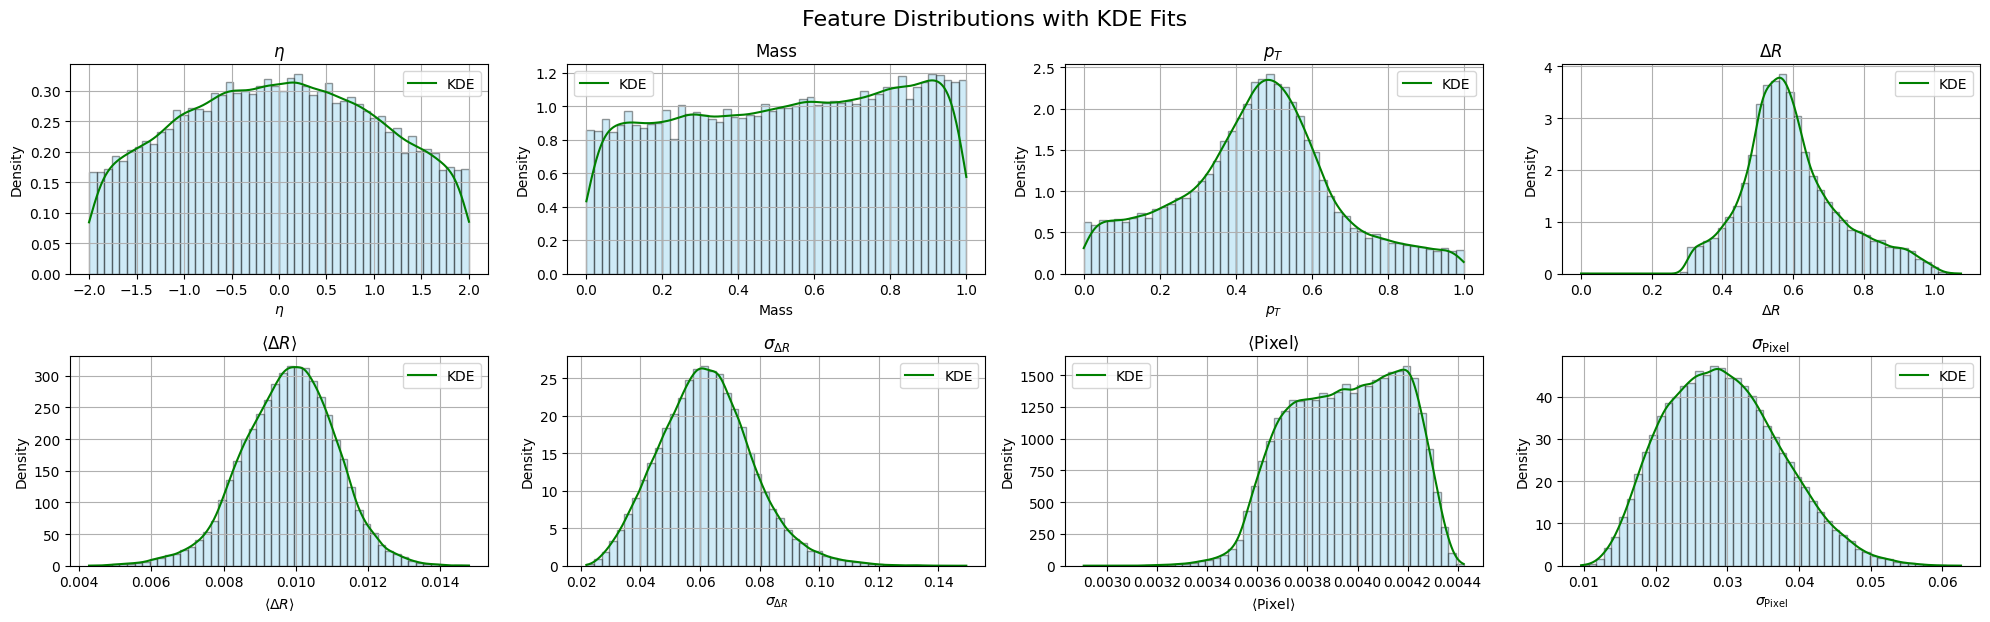

Number of samples: 43633
Image shape: torch.Size([43633, 16, 16])
Feature shape: torch.Size([43633, 9])


In [5]:
# Define variable and dataset
batch_size = 64
lr = 1e-2

X_train, y_train, X_test, y_test, X_val, y_val = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'multiclass')

print(y_test[:])
print(y_train[:])
print(y_val[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

X_batch, y_batch = next(iter(train_loader))

print("Batch X dtype:", X_batch.dtype)
print("Batch y dtype:", y_batch.dtype)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))
print("Number of test samples:", len(test_data))

In [6]:
# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

scheduler_G = CosineAnnealingLR(optimizer_G, T_max=n_epochs, eta_min=1e-4)
scheduler_D = CosineAnnealingLR(optimizer_D, T_max=n_epochs, eta_min=1e-4)

g_losses = []
d_losses = []

# Tracking buffers
stats_dict = {
    'fake_dR_mean': [],
    'fake_dR_std': [],
    'fake_pixel_mean': [],
    'fake_pixel_std': [],
    'real_dR_mean': [],
    'real_dR_std': [],
    'real_pixel_mean': [],
    'real_pixel_std': []
}

dists = compute_distance_map(16,16).to(device)

In [7]:
# Plot visual of generator
# graph =  draw_graph(
#     generator,
#     input_size=(1, 9),
#     expand_nested=True,
#     depth = 1,
#     graph_name="Discriminator Architecture",
#     mode = 'train',
#     show_shapes = True,
#     hide_inner_tensors=True,   # Hides intermediate shapes
#     roll=True,                  # More compact layer grouping
#     save_graph=False,           # Set to True if you want to save
#     # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
#     # edge_attr={"color": "gray"},                          # Edge styling
#     graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
# )

# # Show in notebook
# graph.visual_graph

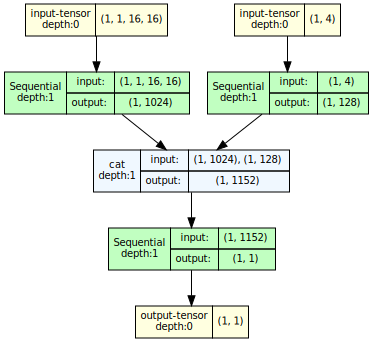

In [8]:
# Plot visual of discriminator
graph2 = draw_graph(
    discriminator,
    input_size=[(1, 1, 16, 16),(1,4)],
    expand_nested=True,
    depth = 1,
    graph_name="Discriminator Architecture",
    mode = 'train',
    show_shapes = True,
    hide_inner_tensors=True,   # Hides intermediate shapes
    roll=True,                  # More compact layer grouping
    save_graph=False,           # Set to True if you want to save
    # node_attr={"color": "lightblue", "style": "filled"},  # Node styling
    # edge_attr={"color": "gray"},                          # Edge styling
    graph_dir= "TB",                         # Layout: TB (top-bottom), LR (left-right)
)
graph2.visual_graph

In [15]:
## Load a previous model
load = False

if load:
    # load_path = "models/ ..." # Path to load your model
    
    # Load the checkpoint
    checkpoint = torch.load(load_path)
    
    # Restore model weights
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    
    # Optionally restore tracking data
    g_losses = checkpoint["g_losses"]
    d_losses = checkpoint["d_losses"]
    
    stats_dict = checkpoint["stats_dict"]
    
    print(f"Loaded model from {load_path}")
    
# Show loaded model performance
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

[Epoch 1/100] [D loss: 0.5046] [G loss: 1.4742] [Validity_loss: 0.4626] 
 [Stat_loss: 1.0101] [NNZ_loss: 0.0015]
Sample feature coding: [1.         0.5290333  0.08323944 0.9622856  0.76763105 0.00951208
 0.07696826 0.00361743 0.0188365 ]


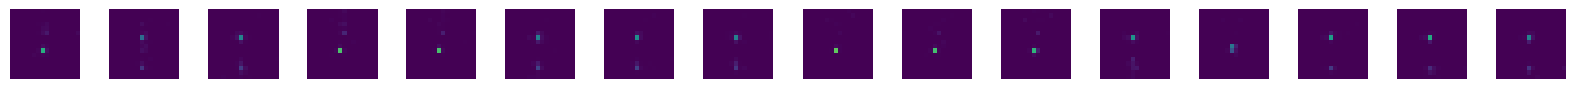

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 2/100] [D loss: 0.4586] [G loss: 1.3022] [Validity_loss: 0.7924] 
 [Stat_loss: 0.5081] [NNZ_loss: 0.0017]
Sample feature coding: [0.         0.3307589  0.6222687  0.33059824 0.579675   0.00868839
 0.07702626 0.00410272 0.02425009]


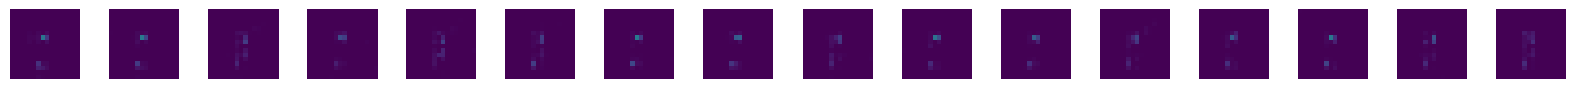

[Epoch 3/100] [D loss: 0.4304] [G loss: 1.3795] [Validity_loss: 0.6136] 
 [Stat_loss: 0.7641] [NNZ_loss: 0.0019]
Sample feature coding: [ 1.         -0.8353124   0.14474139  0.5018116   0.40549585  0.00859664
  0.05851822  0.00390317  0.03285954]


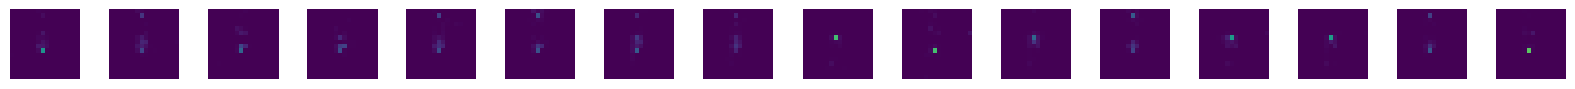

[Epoch 4/100] [D loss: 0.5473] [G loss: 1.3752] [Validity_loss: 0.4836] 
 [Stat_loss: 0.8900] [NNZ_loss: 0.0016]
Sample feature coding: [1.         1.9001358  0.6061303  0.36049592 0.6253323  0.01018338
 0.06106324 0.00415472 0.02964169]


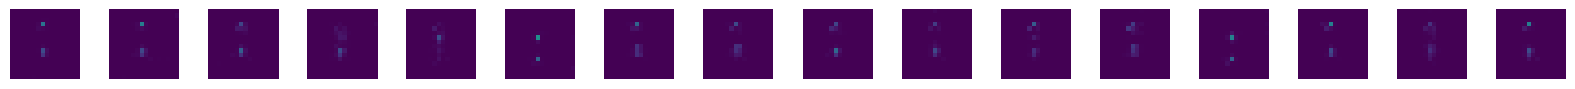

[Epoch 5/100] [D loss: 0.5376] [G loss: 0.9640] [Validity_loss: 0.4509] 
 [Stat_loss: 0.5119] [NNZ_loss: 0.0013]
Sample feature coding: [0.         1.4364613  0.93735576 0.54128104 0.6284038  0.00994171
 0.05257863 0.00365197 0.02501987]


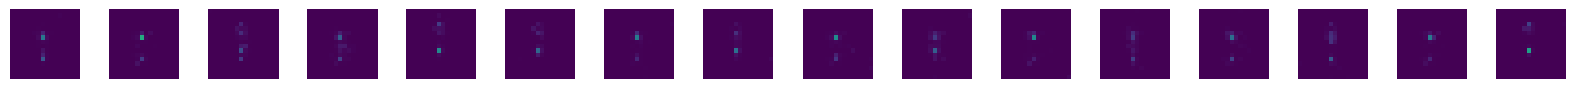

[Epoch 6/100] [D loss: 0.5649] [G loss: 1.0960] [Validity_loss: 0.5739] 
 [Stat_loss: 0.5205] [NNZ_loss: 0.0016]
Sample feature coding: [1.         0.63477445 0.92748845 0.40468773 0.8318629  0.01124857
 0.076266   0.00409345 0.01989321]


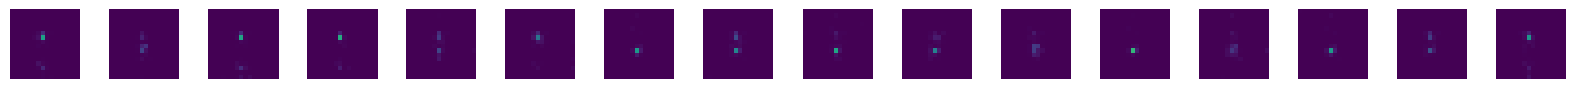

[Epoch 7/100] [D loss: 0.4964] [G loss: 1.1882] [Validity_loss: 0.5334] 
 [Stat_loss: 0.6531] [NNZ_loss: 0.0016]
Sample feature coding: [ 1.         -0.16768385  0.17157751  0.7291991   0.35747665  0.010183
  0.07317331  0.00418225  0.03443101]


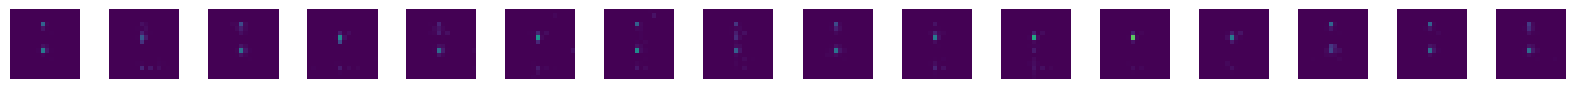

[Epoch 8/100] [D loss: 0.5460] [G loss: 1.1275] [Validity_loss: 0.5086] 
 [Stat_loss: 0.6176] [NNZ_loss: 0.0013]
Sample feature coding: [ 0.         -1.2864718   0.9254906   0.33000615  0.4710152   0.00980111
  0.06300158  0.00418149  0.02916251]


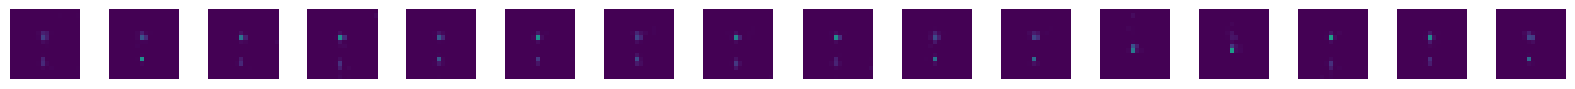

[Epoch 9/100] [D loss: 0.4548] [G loss: 0.9195] [Validity_loss: 0.5066] 
 [Stat_loss: 0.4117] [NNZ_loss: 0.0012]
Sample feature coding: [ 1.         -0.5504117   0.57647604  0.47548506  0.6653747   0.01030848
  0.0549905   0.0036782   0.03197379]


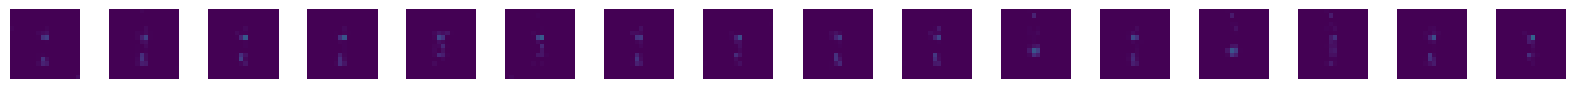

[Epoch 10/100] [D loss: 0.3820] [G loss: 0.9234] [Validity_loss: 0.4866] 
 [Stat_loss: 0.4353] [NNZ_loss: 0.0015]
Sample feature coding: [ 1.         -0.6537296   0.11016539  0.43524182  0.61064583  0.00877558
  0.05739595  0.00409701  0.02844851]


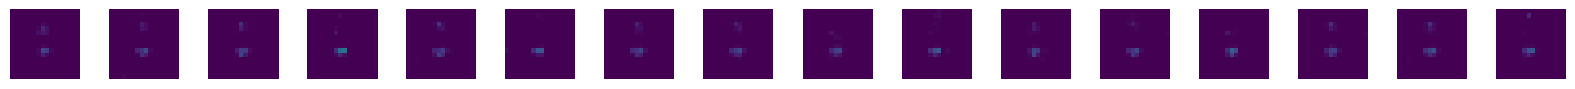

[Epoch 11/100] [D loss: 0.4977] [G loss: 1.1555] [Validity_loss: 0.5526] 
 [Stat_loss: 0.6009] [NNZ_loss: 0.0020]
Sample feature coding: [ 1.         -1.0659447   0.77834934  0.39781713  0.41210943  0.01086077
  0.05845191  0.00400015  0.0240858 ]


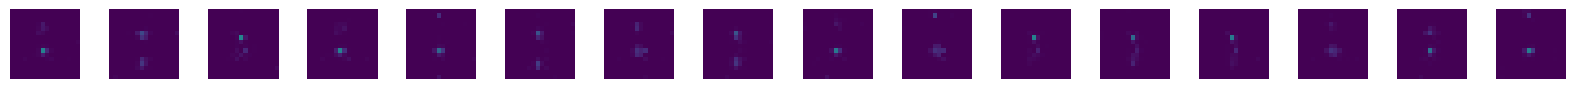

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 12/100] [D loss: 0.4837] [G loss: 0.8515] [Validity_loss: 0.4471] 
 [Stat_loss: 0.4031] [NNZ_loss: 0.0013]
Sample feature coding: [ 0.         -1.4039869   0.8080555   0.09376344  0.4742417   0.01084688
  0.05487224  0.0037056   0.03950742]


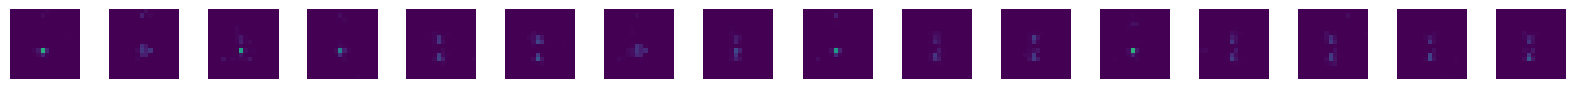

[Epoch 13/100] [D loss: 0.5248] [G loss: 0.9018] [Validity_loss: 0.4996] 
 [Stat_loss: 0.4004] [NNZ_loss: 0.0019]
Sample feature coding: [0.         0.09770311 0.7029053  0.05538261 0.47926873 0.01063367
 0.04416039 0.00354051 0.02443967]


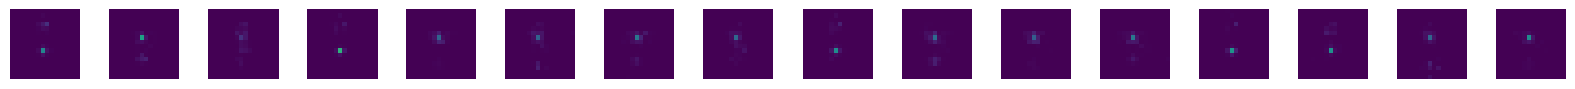

[Epoch 14/100] [D loss: 0.5179] [G loss: 0.9565] [Validity_loss: 0.5412] 
 [Stat_loss: 0.4141] [NNZ_loss: 0.0013]
Sample feature coding: [ 0.         -0.5847554   0.38661245  0.4015282   0.514294    0.01080384
  0.05460256  0.00407966  0.04539612]


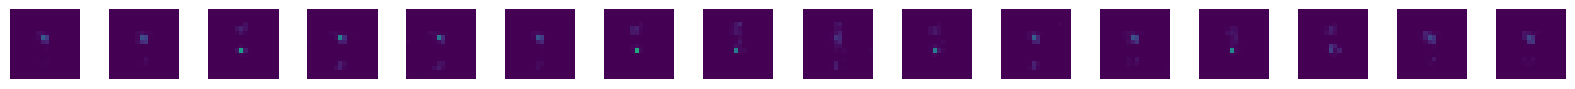

[Epoch 15/100] [D loss: 0.4550] [G loss: 0.9236] [Validity_loss: 0.4754] 
 [Stat_loss: 0.4459] [NNZ_loss: 0.0023]
Sample feature coding: [ 1.         -0.03799503  0.07252127  0.53700024  0.5281783   0.01009253
  0.06885425  0.0036875   0.02658807]


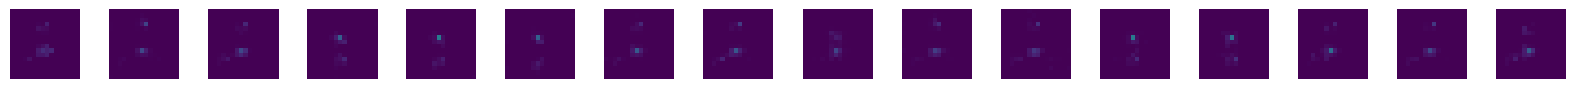

[Epoch 16/100] [D loss: 0.4238] [G loss: 1.1125] [Validity_loss: 0.4286] 
 [Stat_loss: 0.6800] [NNZ_loss: 0.0039]
Sample feature coding: [1.         0.8941385  0.44091037 0.32226446 0.6553422  0.00615253
 0.10487184 0.00423066 0.03425073]


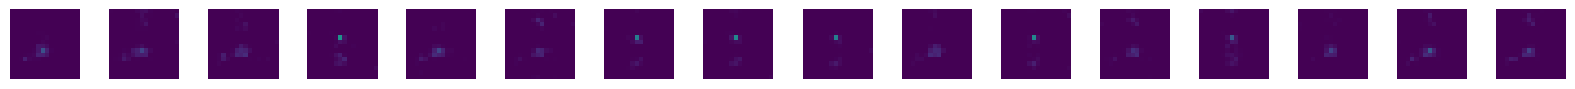

[Epoch 17/100] [D loss: 0.5185] [G loss: 0.8255] [Validity_loss: 0.4883] 
 [Stat_loss: 0.3356] [NNZ_loss: 0.0016]
Sample feature coding: [ 1.         -0.74390453  0.5616151   0.27342156  0.52987933  0.00783776
  0.05630357  0.00362982  0.03541033]


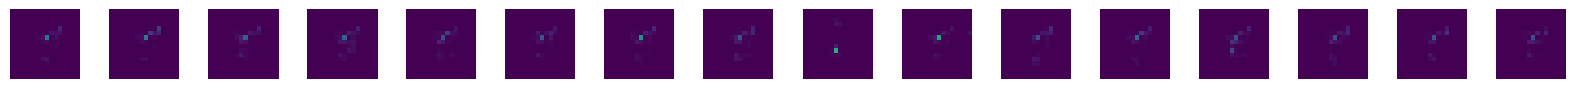

[Epoch 18/100] [D loss: 0.4738] [G loss: 0.9494] [Validity_loss: 0.5711] 
 [Stat_loss: 0.3768] [NNZ_loss: 0.0016]
Sample feature coding: [ 1.         -0.9825153   0.71399206  0.40066826  0.77739507  0.00810729
  0.05642598  0.00395316  0.01769682]


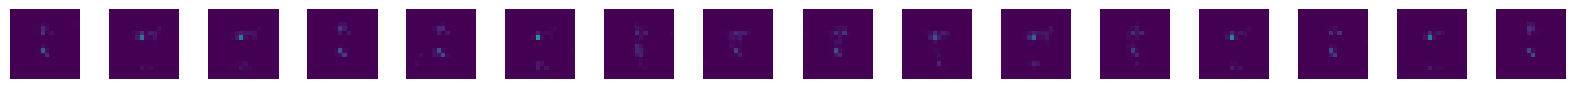

[Epoch 19/100] [D loss: 0.4484] [G loss: 1.4937] [Validity_loss: 0.7614] 
 [Stat_loss: 0.7309] [NNZ_loss: 0.0013]
Sample feature coding: [ 1.         -0.11691727  0.28303942  0.0638572   0.7841323   0.00862861
  0.05553694  0.00424088  0.03023636]


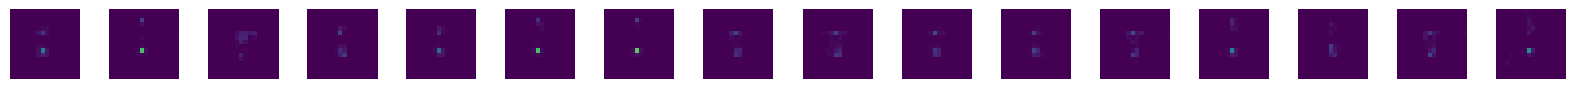

[Epoch 20/100] [D loss: 0.3965] [G loss: 1.0205] [Validity_loss: 0.5855] 
 [Stat_loss: 0.4333] [NNZ_loss: 0.0017]
Sample feature coding: [ 0.         -0.6704814   0.2470434   0.61944234  0.7775904   0.00947933
  0.04684777  0.00410409  0.0289237 ]


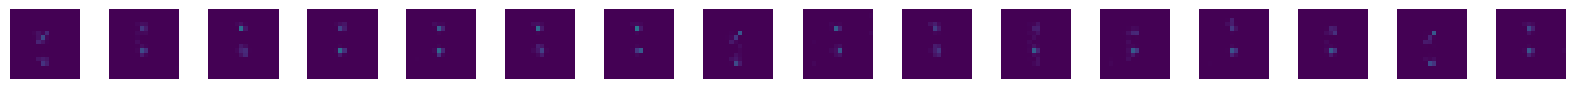

[Epoch 21/100] [D loss: 0.4558] [G loss: 0.8813] [Validity_loss: 0.5265] 
 [Stat_loss: 0.3530] [NNZ_loss: 0.0018]
Sample feature coding: [ 1.         -0.08997392  0.8358044   0.251766    0.592943    0.00915602
  0.08310831  0.00376183  0.0323947 ]


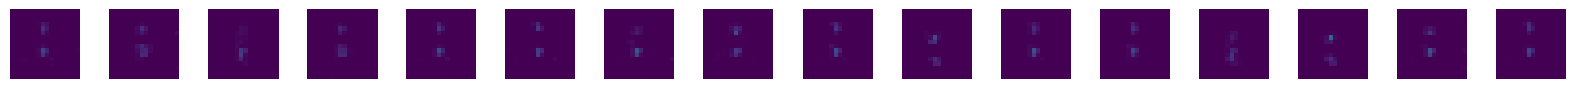

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 22/100] [D loss: 0.4816] [G loss: 0.9119] [Validity_loss: 0.3809] 
 [Stat_loss: 0.5293] [NNZ_loss: 0.0017]
Sample feature coding: [ 0.         -0.78210247  0.17509103  0.24706176  0.8978973   0.00863678
  0.02842093  0.00349291  0.0345553 ]


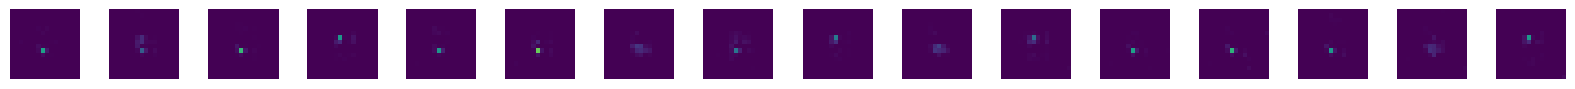

[Epoch 23/100] [D loss: 0.5667] [G loss: 1.0109] [Validity_loss: 0.4907] 
 [Stat_loss: 0.5189] [NNZ_loss: 0.0013]
Sample feature coding: [ 0.         -0.18008876  0.8589038   0.49449238  0.829864    0.01087802
  0.0629384   0.00370343  0.01958453]


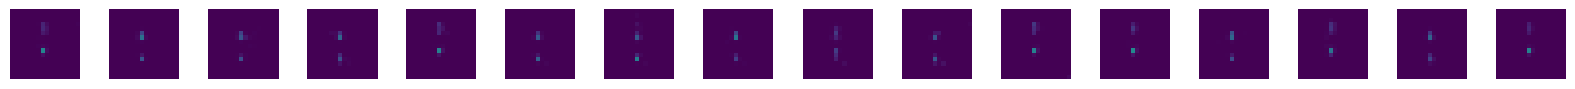

[Epoch 24/100] [D loss: 0.5363] [G loss: 1.0467] [Validity_loss: 0.5326] 
 [Stat_loss: 0.5122] [NNZ_loss: 0.0019]
Sample feature coding: [1.         1.347783   0.7580029  0.03693993 0.88110876 0.00938124
 0.06763045 0.003905   0.02715755]


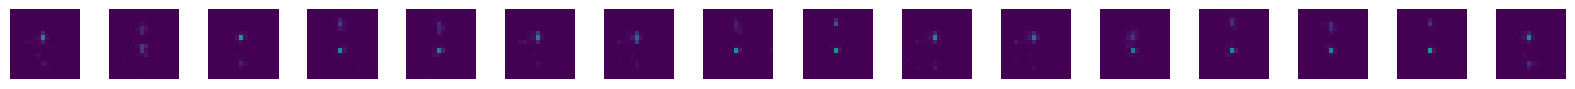

[Epoch 25/100] [D loss: 0.5148] [G loss: 0.8658] [Validity_loss: 0.4976] 
 [Stat_loss: 0.3661] [NNZ_loss: 0.0021]
Sample feature coding: [0.         1.8891778  0.8894552  0.24772377 0.52333856 0.00910747
 0.06910619 0.00428964 0.0155466 ]


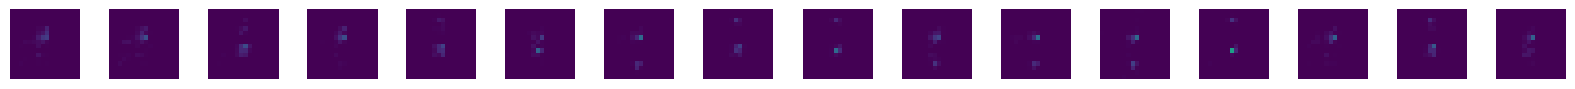

[Epoch 26/100] [D loss: 0.3895] [G loss: 1.4313] [Validity_loss: 0.6600] 
 [Stat_loss: 0.7692] [NNZ_loss: 0.0021]
Sample feature coding: [ 0.         -1.7610997   0.7749375   0.50493675  0.5128973   0.01021085
  0.0791636   0.0042475   0.03326511]


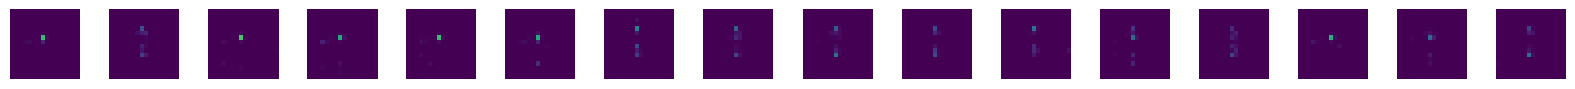

[Epoch 27/100] [D loss: 0.4026] [G loss: 1.2552] [Validity_loss: 0.6093] 
 [Stat_loss: 0.6444] [NNZ_loss: 0.0016]
Sample feature coding: [0.         0.21415731 0.12492672 0.33598956 0.8310237  0.00926864
 0.04976929 0.00427257 0.03117871]


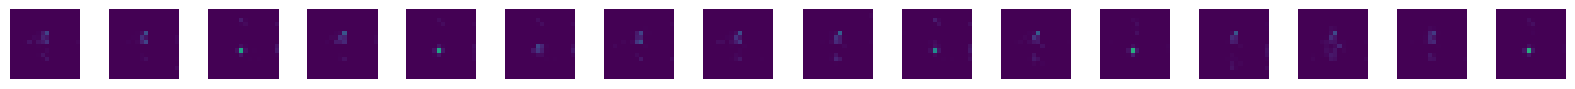

[Epoch 28/100] [D loss: 0.4963] [G loss: 1.1502] [Validity_loss: 0.5477] 
 [Stat_loss: 0.6007] [NNZ_loss: 0.0018]
Sample feature coding: [1.         0.64482963 0.93489414 0.1486628  0.48883003 0.00776877
 0.05277855 0.00417577 0.02136028]


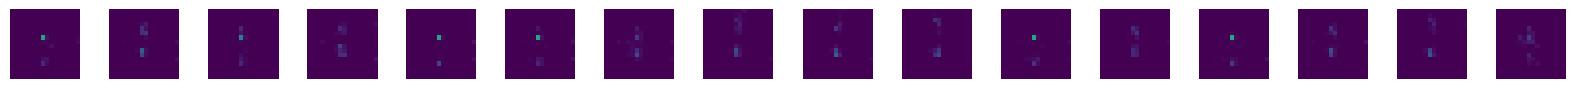

[Epoch 29/100] [D loss: 0.3439] [G loss: 1.5558] [Validity_loss: 0.6645] 
 [Stat_loss: 0.8898] [NNZ_loss: 0.0016]
Sample feature coding: [ 1.         -0.23373865  0.786401    0.49586022  0.59591335  0.01009305
  0.07574943  0.00381911  0.01755203]


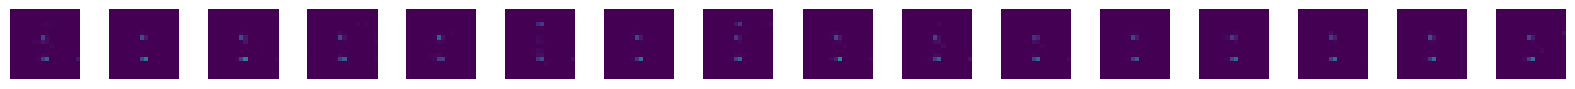

[Epoch 30/100] [D loss: 0.6701] [G loss: 2.1706] [Validity_loss: 0.7288] 
 [Stat_loss: 1.4385] [NNZ_loss: 0.0033]
Sample feature coding: [ 1.         -0.6119462   0.9252076   0.5178279   0.61184305  0.00934013
  0.07043622  0.00376838  0.02687082]


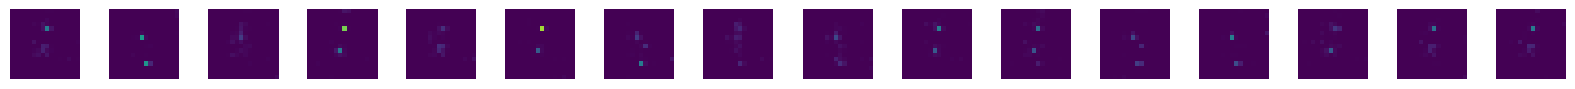

[Epoch 31/100] [D loss: 0.4631] [G loss: 1.0513] [Validity_loss: 0.5410] 
 [Stat_loss: 0.5088] [NNZ_loss: 0.0015]
Sample feature coding: [1.         0.5464126  0.5984777  0.4593201  0.61984074 0.00776805
 0.05675193 0.00399522 0.02248464]


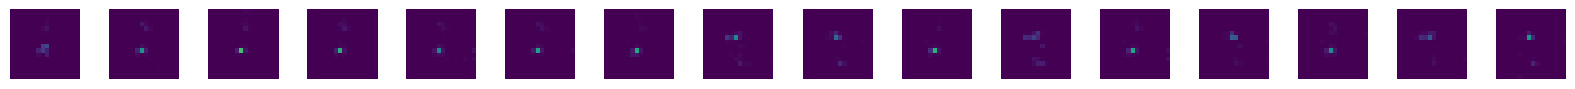

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 32/100] [D loss: 0.3540] [G loss: 0.9732] [Validity_loss: 0.6489] 
 [Stat_loss: 0.3226] [NNZ_loss: 0.0017]
Sample feature coding: [ 1.         -1.1364987   0.00919717  0.7838801   0.46779484  0.01074017
  0.05630732  0.00419216  0.0359662 ]


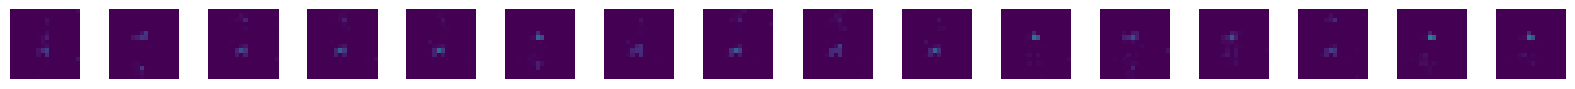

[Epoch 33/100] [D loss: 0.4892] [G loss: 0.8613] [Validity_loss: 0.5680] 
 [Stat_loss: 0.2918] [NNZ_loss: 0.0016]
Sample feature coding: [0.         1.5719229  0.70090556 0.34561306 0.5634538  0.00885452
 0.04705663 0.00377989 0.01734819]


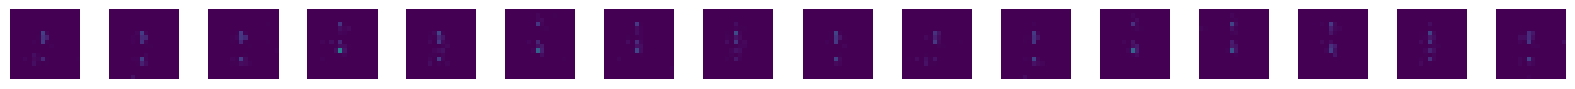

[Epoch 34/100] [D loss: 0.3776] [G loss: 1.1805] [Validity_loss: 0.6435] 
 [Stat_loss: 0.5351] [NNZ_loss: 0.0019]
Sample feature coding: [ 1.         -0.88509804  0.5081512   0.36468348  0.6578928   0.01196073
  0.06807236  0.00401254  0.02481251]


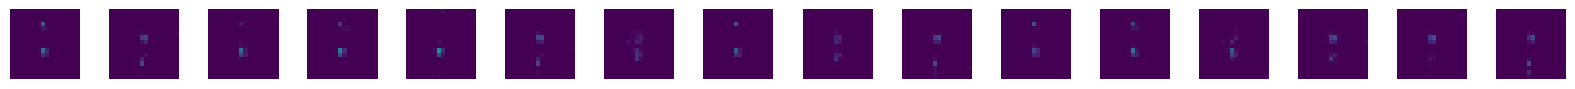

[Epoch 35/100] [D loss: 0.5412] [G loss: 1.1231] [Validity_loss: 0.5693] 
 [Stat_loss: 0.5517] [NNZ_loss: 0.0022]
Sample feature coding: [ 1.         -0.7022935   0.66855824  0.27759862  0.5561491   0.01094647
  0.05504895  0.00411465  0.03839578]


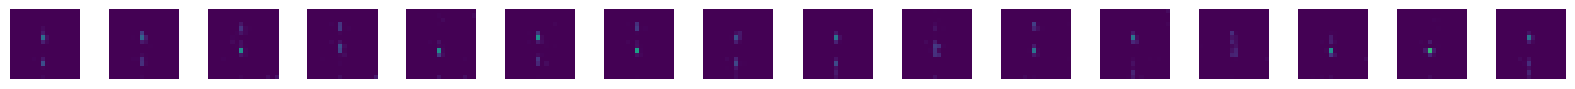

[Epoch 36/100] [D loss: 0.5307] [G loss: 1.2733] [Validity_loss: 0.5006] 
 [Stat_loss: 0.7713] [NNZ_loss: 0.0014]
Sample feature coding: [ 0.         -0.38925332  0.916532    0.6786191   0.68320954  0.0095415
  0.05373571  0.00433577  0.02977047]


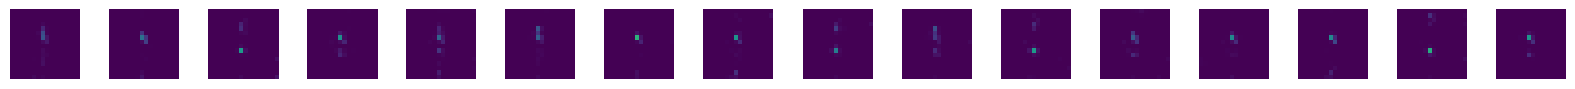

[Epoch 37/100] [D loss: 0.5857] [G loss: 1.1483] [Validity_loss: 0.5173] 
 [Stat_loss: 0.6290] [NNZ_loss: 0.0020]
Sample feature coding: [1.         0.2626286  0.4900441  0.5856345  0.7889244  0.01018625
 0.03759366 0.00410981 0.0204349 ]


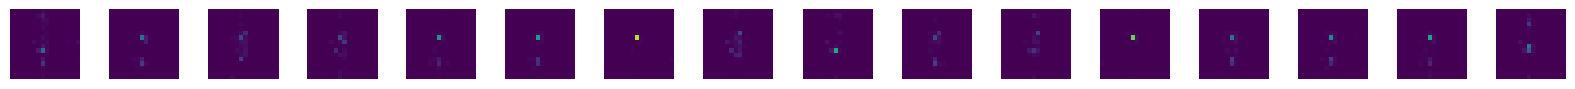

[Epoch 38/100] [D loss: 0.6049] [G loss: 1.2944] [Validity_loss: 0.5087] 
 [Stat_loss: 0.7845] [NNZ_loss: 0.0012]
Sample feature coding: [ 1.         -1.1392511   0.12907663  0.35261095  0.45475784  0.00820517
  0.07147469  0.00349166  0.03033848]


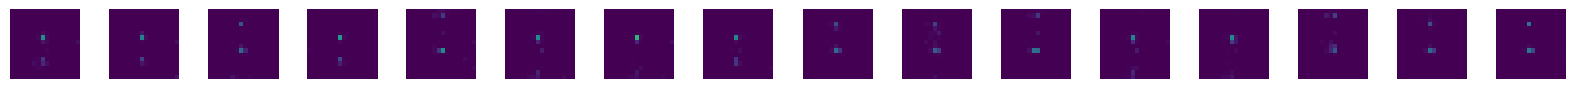

[Epoch 39/100] [D loss: 0.5134] [G loss: 1.1544] [Validity_loss: 0.5055] 
 [Stat_loss: 0.6472] [NNZ_loss: 0.0017]
Sample feature coding: [1.         0.5670663  0.5804083  0.5116027  0.69774175 0.01098989
 0.05056465 0.00378281 0.03058776]


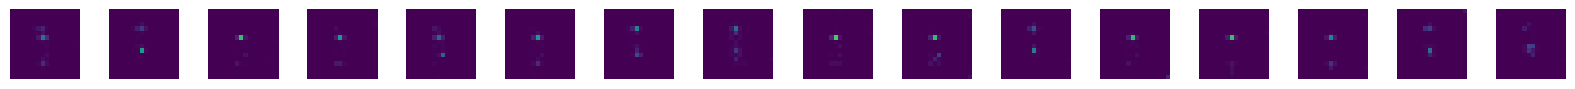

[Epoch 40/100] [D loss: 0.5361] [G loss: 1.1641] [Validity_loss: 0.4282] 
 [Stat_loss: 0.7334] [NNZ_loss: 0.0025]
Sample feature coding: [1.         0.86733556 0.439274   0.47357726 0.56909114 0.01032873
 0.05896971 0.00375386 0.01986282]


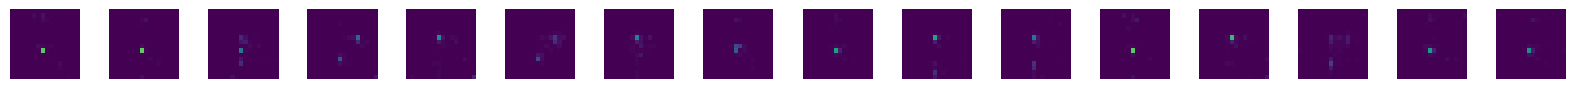

[Epoch 41/100] [D loss: 0.5313] [G loss: 1.1863] [Validity_loss: 0.5496] 
 [Stat_loss: 0.6354] [NNZ_loss: 0.0013]
Sample feature coding: [1.         0.47917852 0.6209465  0.60517675 0.50331616 0.01065271
 0.06642215 0.00422511 0.04959378]


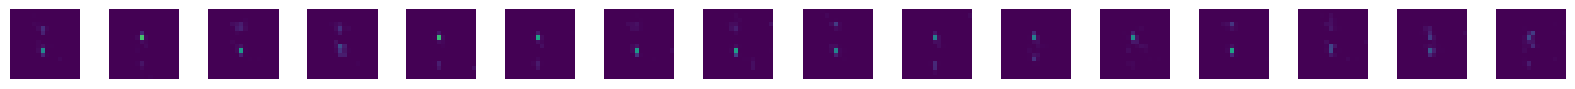

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 42/100] [D loss: 0.5563] [G loss: 1.0593] [Validity_loss: 0.4910] 
 [Stat_loss: 0.5666] [NNZ_loss: 0.0018]
Sample feature coding: [1.         0.26445967 0.37204996 0.46381918 0.5227964  0.00977062
 0.06608593 0.00390881 0.02888612]


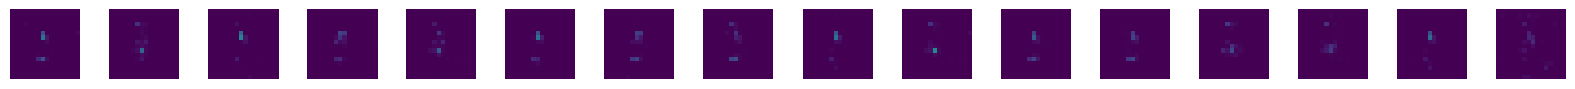

[Epoch 43/100] [D loss: 0.5051] [G loss: 0.9693] [Validity_loss: 0.4944] 
 [Stat_loss: 0.4733] [NNZ_loss: 0.0017]
Sample feature coding: [ 0.         -0.42889166  0.9162332   0.65550315  0.566328    0.01190654
  0.04966861  0.00416595  0.02566837]


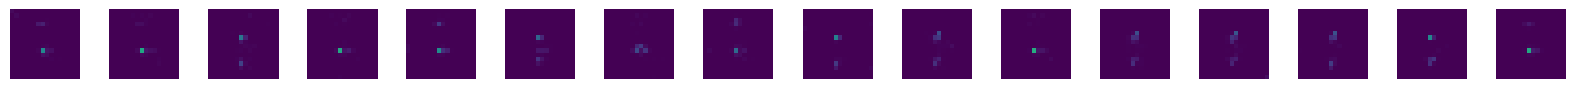

[Epoch 44/100] [D loss: 0.5159] [G loss: 1.0658] [Validity_loss: 0.5449] 
 [Stat_loss: 0.5192] [NNZ_loss: 0.0017]
Sample feature coding: [0.         0.55204874 0.03392579 0.10036959 0.8030459  0.00874904
 0.04758618 0.00384013 0.03797116]


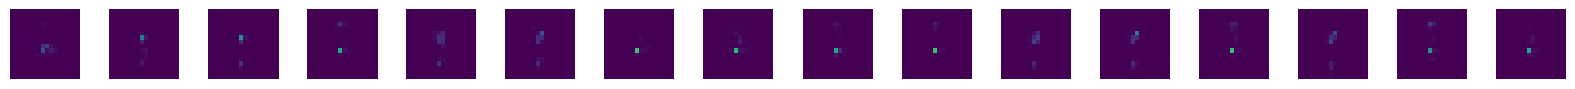

[Epoch 45/100] [D loss: 0.5342] [G loss: 1.2869] [Validity_loss: 0.5600] 
 [Stat_loss: 0.7231] [NNZ_loss: 0.0039]
Sample feature coding: [1.         0.70641965 0.47734225 0.48566955 0.56350505 0.01003602
 0.0914716  0.00401277 0.01879055]


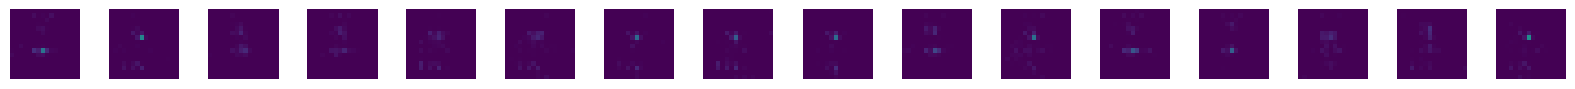

[Epoch 46/100] [D loss: 0.4652] [G loss: 1.2030] [Validity_loss: 0.5824] 
 [Stat_loss: 0.6189] [NNZ_loss: 0.0017]
Sample feature coding: [ 1.         -1.8540539  -0.07009733  0.42712063  0.53842956  0.00938802
  0.05298811  0.00425273  0.04451508]


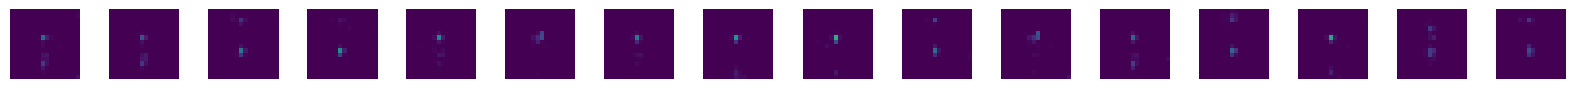

[Epoch 47/100] [D loss: 0.5335] [G loss: 1.2281] [Validity_loss: 0.5253] 
 [Stat_loss: 0.7007] [NNZ_loss: 0.0021]
Sample feature coding: [0.         0.8341997  0.10098159 0.4470345  0.4931253  0.01186225
 0.04337685 0.00412597 0.04207088]


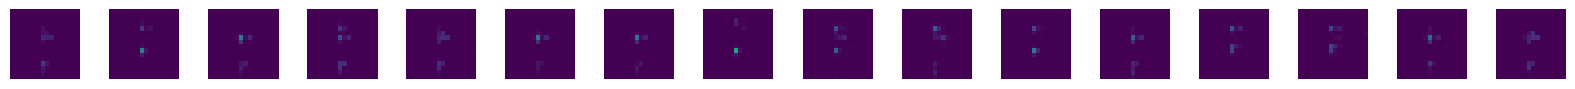

[Epoch 48/100] [D loss: 0.5363] [G loss: 1.0505] [Validity_loss: 0.5848] 
 [Stat_loss: 0.4640] [NNZ_loss: 0.0017]
Sample feature coding: [ 1.          0.7107969   0.22381932 -0.02285388  0.43652254  0.01075868
  0.07326625  0.00425957  0.02364053]


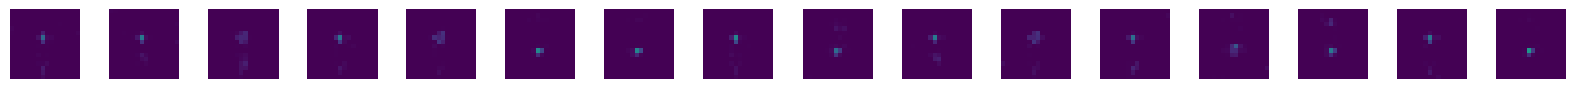

[Epoch 49/100] [D loss: 0.5169] [G loss: 0.9483] [Validity_loss: 0.4945] 
 [Stat_loss: 0.4515] [NNZ_loss: 0.0023]
Sample feature coding: [ 0.         -1.4354291   0.40918285  0.5880589   0.6141538   0.00868433
  0.07114512  0.00408317  0.03085679]


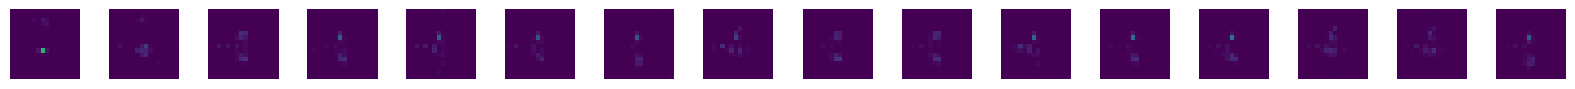

[Epoch 50/100] [D loss: 0.5280] [G loss: 1.2091] [Validity_loss: 0.4711] 
 [Stat_loss: 0.7365] [NNZ_loss: 0.0015]
Sample feature coding: [0.         1.0307481  0.7311436  0.38200974 0.64105374 0.01051964
 0.06182324 0.00410881 0.02663701]


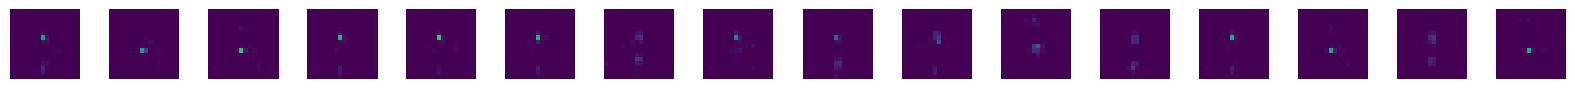

[Epoch 51/100] [D loss: 0.5269] [G loss: 1.0883] [Validity_loss: 0.5153] 
 [Stat_loss: 0.5716] [NNZ_loss: 0.0015]
Sample feature coding: [1.         1.6162088  0.10521568 0.4739238  0.43160376 0.01016588
 0.05020864 0.00362218 0.03509787]


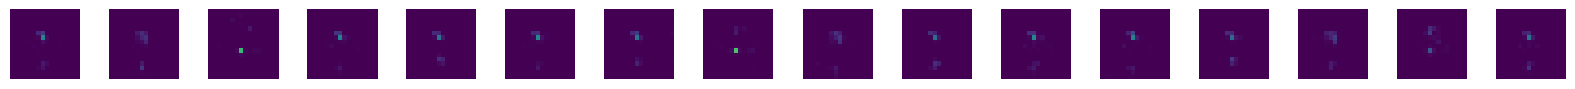

Model and statistics saved to models/class_gan_model_temp.pt
[Epoch 52/100] [D loss: 0.5983] [G loss: 0.9993] [Validity_loss: 0.5794] 
 [Stat_loss: 0.4182] [NNZ_loss: 0.0017]
Sample feature coding: [1.         1.8296841  0.7051241  0.57023317 0.5564167  0.01013375
 0.04489068 0.00374113 0.04158282]


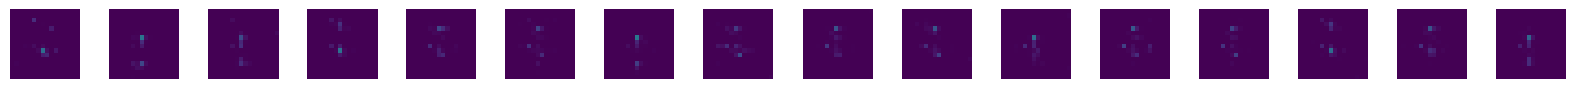

[Epoch 53/100] [D loss: 0.5377] [G loss: 1.0211] [Validity_loss: 0.5107] 
 [Stat_loss: 0.5083] [NNZ_loss: 0.0020]
Sample feature coding: [1.         1.5869278  0.62274706 0.48271278 0.5736404  0.01101075
 0.07928529 0.00396958 0.03924329]


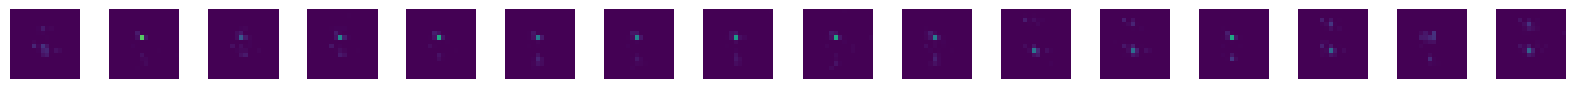

[Epoch 54/100] [D loss: 0.5163] [G loss: 1.3350] [Validity_loss: 0.5122] 
 [Stat_loss: 0.8211] [NNZ_loss: 0.0017]
Sample feature coding: [ 1.         -1.689844    0.8038977   0.5272247   0.531229    0.01102283
  0.0662894   0.00408585  0.02452807]


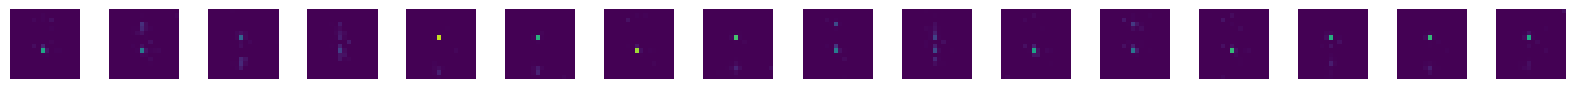

[Epoch 55/100] [D loss: 0.6368] [G loss: 1.2906] [Validity_loss: 0.5453] 
 [Stat_loss: 0.7438] [NNZ_loss: 0.0016]
Sample feature coding: [ 0.         -0.62957114  0.7967066   0.53916895  0.42175204  0.01130075
  0.05708801  0.00394435  0.03409773]


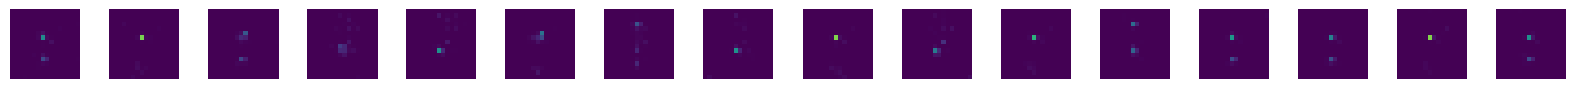

[Epoch 56/100] [D loss: 0.5736] [G loss: 1.0245] [Validity_loss: 0.4812] 
 [Stat_loss: 0.5422] [NNZ_loss: 0.0011]
Sample feature coding: [0.         1.5255498  0.32105574 0.10363424 0.71005    0.00869194
 0.05620991 0.00413477 0.0252035 ]


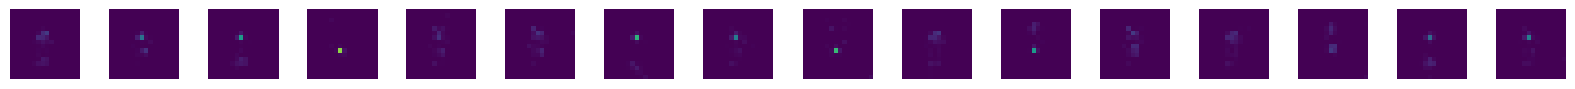

KeyboardInterrupt: 

In [10]:
# Training loop
if True:
    for epoch in range(n_epochs):
        for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
            
            # All real data are normalized in the dataloader
            real_feat = real_features.to(device)
            real_flipped_feat = flipped_features.to(device)
            real_img = real_image.unsqueeze(1).to(device)
            real_flipped_img = flipped_image.unsqueeze(1).to(device)
    
            # print(f"Real: {real_img.shape}")
    
            # Codings will be label, eta, pT, mass that get passed directly to the discriminator
            # All feature values get passed to the generator, then the output image passed to the discriminator
    
            # Discriminator training
            if i % 3 == 0:
                optimizer_D.zero_grad()
                discriminator.train()
                # Generate fake samples
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)

                # Generate the fake image
                fake_img = generator(z_codings)
                # print(f"Fake: {fake_img.shape}")
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1

                fake_flipped_img = generator(flipped_z_codings)
    
                # Get predictions and labels
                real_disc_codings = real_feat[:,:num]
                real_flipped_disc_codings = real_flipped_feat[:,:num]
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]

                # Discriminator gets codings + image
                real_pred = discriminator(real_img, real_disc_codings)
                real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
                fake_pred = discriminator(fake_img, fake_disc_codings)
                fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)
    
                preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)

                # Labels
                ones = torch.ones(2*len(fake_pred))
                zeros = torch.zeros(2*len(real_pred))
                labels = (torch.cat([ones, zeros], dim=0)).to(device)
    
                # Discriminator loss is just its ability to distinguish
                d_loss = torch.nn.BCELoss()(preds, labels)
    
                d_loss.backward()
                optimizer_D.step()
    
            # Generator Training
            if i % 1 == 0:
                optimizer_G.zero_grad()
                generator.train()
                
                # Generate fake data
                # Should be very easy to modify which values are passed as codings
                z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                      sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                      dim=1).to(device)
    
                # Generate image
                fake_img = generator(z_codings)
    
                # Generate eta-flipped data
                flipped_z_codings = z_codings.clone()
                flipped_z_codings[:, 1] *= -1

                fake_flipped_img = generator(flipped_z_codings)

                ## BCE Discriminator Loss
                # Discriminator gets codings + generated image
                fake_disc_codings = z_codings[:,:num]
                fake_flipped_disc_codings = flipped_z_codings[:,:num]

                # Get predictions and labels
                fake_pred = discriminator(fake_img, fake_disc_codings)
                fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

                target = torch.ones_like(fake_pred)
                bce = nn.BCELoss()
                validity_loss = bce(fake_pred, target) + bce(fake_flipped_pred, target)
    
                ## Stat loss
                # Compute statistics for original and flipped fake images
                fake_stats_orig = compute_fake_statistics(fake_img.to('cpu'), dists.to('cpu'))
                fake_stats_flip = compute_fake_statistics(fake_flipped_img.to('cpu'), dists.to('cpu'))
                
                # Average the statistics
                fake_stats = {
                    'fake_dR_mean': 0.5 * (fake_stats_orig['fake_dR_mean'] + fake_stats_flip['fake_dR_mean']),
                    'fake_dR_std': 0.5 * (fake_stats_orig['fake_dR_std'] + fake_stats_flip['fake_dR_std']),
                    'fake_pixel_mean': 0.5 * (fake_stats_orig['fake_pixel_mean'] + fake_stats_flip['fake_pixel_mean']),
                    'fake_pixel_std': 0.5 * (fake_stats_orig['fake_pixel_std'] + fake_stats_flip['fake_pixel_std']),
                }
                
                # Move to device
                fake_dR_mean = fake_stats['fake_dR_mean'].to(device)
                fake_dR_std = fake_stats['fake_dR_std'].to(device)
                fake_pixel_mean = fake_stats['fake_pixel_mean'].to(device)
                fake_pixel_std = fake_stats['fake_pixel_std'].to(device)
                
                # Get real stats from z_codings (features 5–8)
                real_dR_mean = z_codings[:,5]
                real_dR_std = z_codings[:,6]
                real_pixel_mean = z_codings[:,7]
                real_pixel_std = z_codings[:,8]
                
                real_stats = {
                    'real_dR_mean': real_dR_mean,
                    'real_dR_std': real_dR_std,
                    'real_pixel_mean': real_pixel_mean,
                    'real_pixel_std': real_pixel_std
                }
                
                # stats_dict = track_statistics(fake_stats, real_stats)
                # plot_tracked_statistics(stats_dict)
                
                if n_epochs - epoch <= 10:
                    # Track the last statistics
                    stats_dict = track_statistics(fake_stats, real_stats)
                    plot_tracked_statistics(stats_dict)
                
                # Statistical KL Divergence loss
                kl_total = 0
                kl1 = kde_kl_divergence_torch(real_dR_mean / batch_size, fake_dR_mean) / 0.000003
                # print(f"KL(real_dR_mean, fake_dR_mean) = {kl1.item()}")
                
                kl2 = kde_kl_divergence_torch(real_dR_std / batch_size, fake_dR_std) / 0.004
                # print(f"KL(real_dR_std, fake_dR_std) = {kl2.item()}")
                
                kl3 = kde_kl_divergence_torch(real_pixel_mean / batch_size, fake_pixel_mean) / 0.00000002
                # print(f"KL(real_pixel_mean, fake_pixel_mean) = {kl3.item()}")
                
                kl4 = kde_kl_divergence_torch(real_pixel_std / batch_size, fake_pixel_std) / 0.0001
                # print(f"KL(real_pixel_std, fake_pixel_std) = {kl4.item()}")

                kl_total = kl1 + kl2 + kl3 + kl4

                stat_loss = kl_total

                # Number non-zero loss
                fake_nnz = soft_count_nonzero(fake_img, threshold=3e-5, sharpness=10000.0)
                real_nnz = soft_count_nonzero(real_img, threshold=3e-5, sharpness=10000.0)
                nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)


                # Total generator loss is the average of the discriminator's predictions of the original and flipped data
                # + number of non-zero pixels loss
                # + the difference between input and output dR and pixel statistics

                alpha = .2
                beta = .00002
                chi = .03

                g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

                g_loss.backward()
                optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[-1]:.4f}] [G loss: {g_losses[-1]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

        plot_generated_samples(generator, dataset, kdes, batch_size=16, latent_dim=256)

        if epoch % 10 == 0:
            # Save model states and tracked data in a temp file during training
            save_path = f"models/q_gan_model_temp.pt"
            torch.save({
                "generator_state_dict": generator.state_dict(),
                "discriminator_state_dict": discriminator.state_dict(),
                "g_losses": g_losses,
                "d_losses": d_losses,
                "stats_dict": stats_dict
            }, save_path)

            print(f"Model and statistics saved to {save_path}")

In [11]:
## Save Model
# Create output directory if it doesn't exist
save = True

if save:
    os.makedirs("models", exist_ok=True)
    
    # Timestamp for unique filenames
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # Save model states and tracked data in a single file
    save_path = f"models/1_layer_Fully_connected_QGAN_works_really_well_{timestamp}.pt"
    torch.save({
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "g_losses": g_losses,
        "d_losses": d_losses,
        "stats_dict": stats_dict
    }, save_path)
    
    print(f"Model and statistics saved to {save_path}")

Model and statistics saved to models/1_layer_Fully_connected_QGAN_works_really_well_0724_1000.pt


![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

In [ ]:
plot_real_samples(dataset)

Sample feature coding: [1.         0.560489   0.60503143 0.88607    0.5888316  0.00807569
 0.04965619 0.00416818 0.04253429]


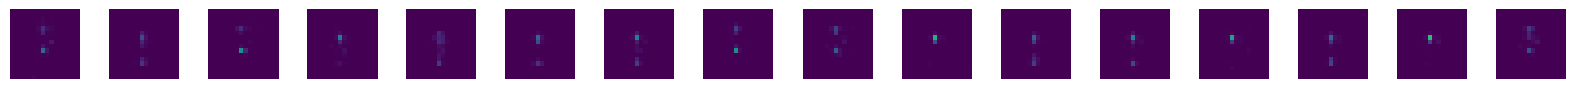

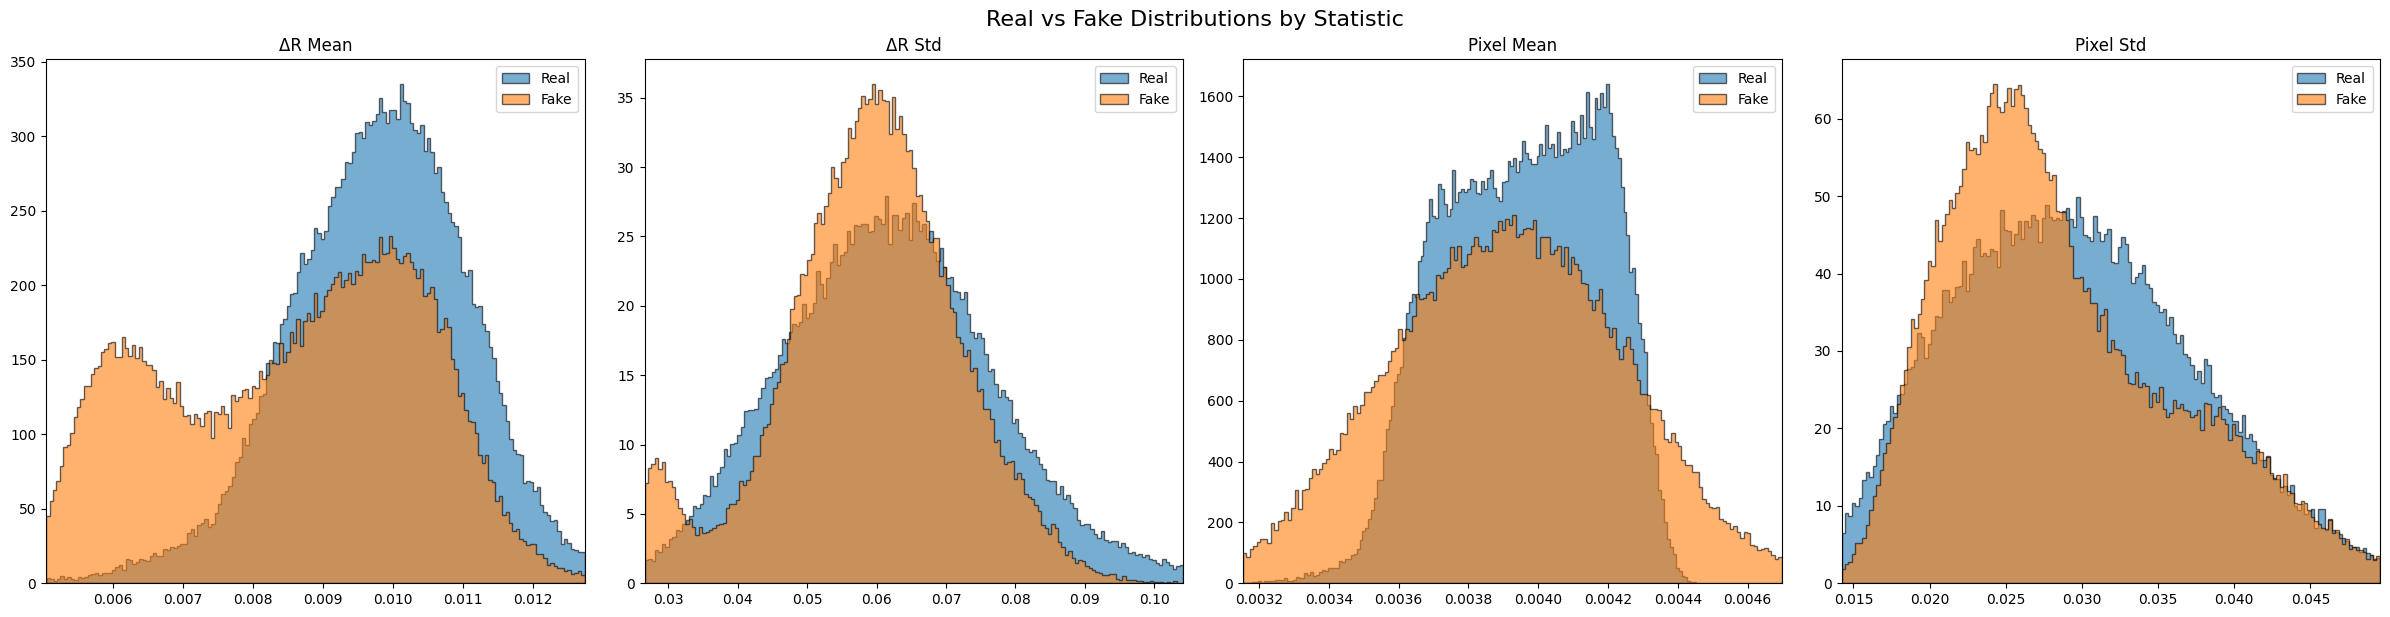

Discriminator output (wrong label): [0.8422825  0.8816788  0.59564096 ... 0.72135156 0.9995316  0.518515  ]
Discriminator output (correct label): [0.39289168 0.56326246 0.4258966  ... 0.634142   0.9646069  0.72912693]
Real labels: [1. 1. 1. ... 1. 1. 1.]
Swapped labels: [0. 0. 0. ... 0. 0. 0.]
Relative change (%): [114.38033    56.530727   39.855766  ...  13.752377    3.6206245
 -28.885496 ]


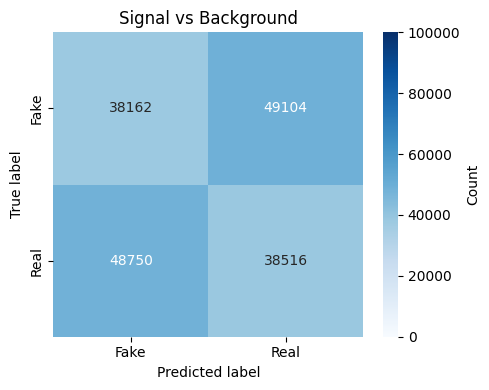

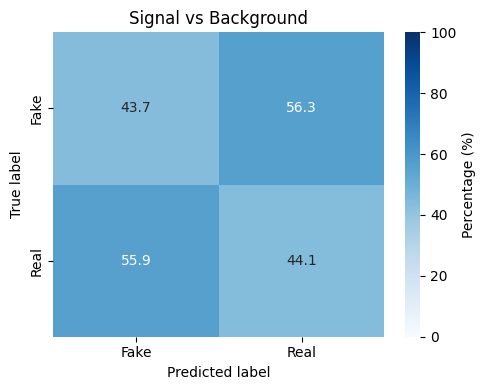

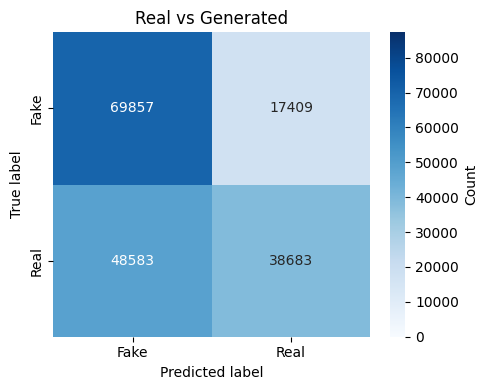

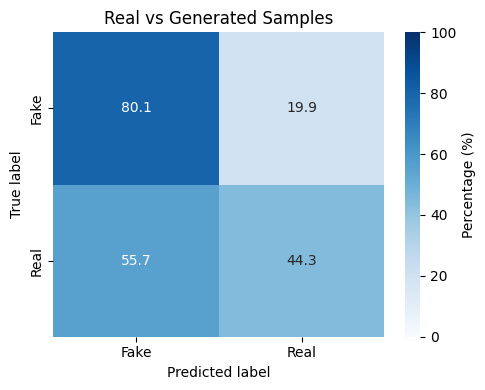

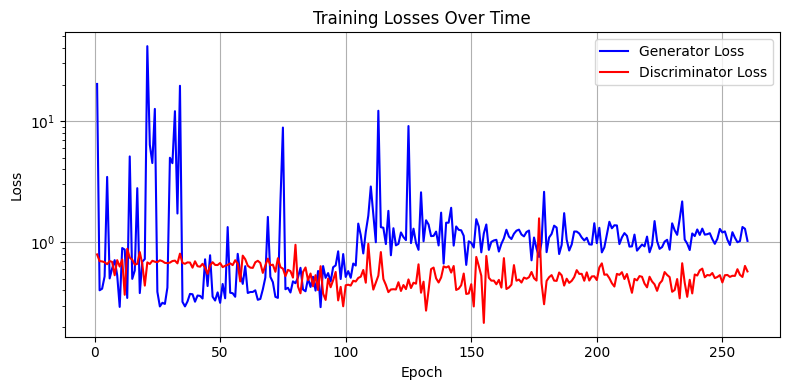

In [13]:
test_generated_samples(generator, discriminator, dataset, kdes, batch_size=100000)

# Optional args:
#     generator,
#     discriminator,
#     dataset,
#     kdes,
#     batch_size=16,
#     latent_dim=256,
#     codings=None,
#     plot_distributions=True,
#     compare_discriminator=True

plot_metrics(g_losses, d_losses)